In [4]:
import geopandas as gpd #handle shape file 
import matplotlib.pyplot as plt #Make graph

import numpy as np #Mathematical functions
import pandas as pd #

from shapely import wkt
#import geopy.distance
from math import radians, cos, sin, asin, sqrt

from pandas.core.frame import DataFrame
from functools import reduce
import pyproj as pp
from pyproj import Proj


from pylab import rcParams 
rcParams['figure.figsize'] = 15,15

import warnings
warnings.filterwarnings('ignore')

# Part 2: How much distance a families whom have a social beneficities ..

In [5]:
#Parroquias Urbanas de Quito 
# This shape file was cleaned in the part 1. 

df_uquito= gpd.read_file('../data/Quito Urbano/Quito_Urbano.shp')
df_MIES= gpd.read_file('../data/MIES points/MIES_points.shp')

In [6]:
#Database from MIES

#Clean information and make a shape file with MIES centers point in D.M. Quito.

#Location of MIES Centers
df_mies_c= pd.read_excel("https://info.inclusion.gob.ec/images/usuarios_externos/2023/ua_coord_validadas_ago2023.xlsx")

#drop NA.
df_mies_c.dropna(subset=['x'], inplace = True )

#Reproject to EPSG 32733. using information of Ecuador (Zone=17 and ellps=WGS84)
projWGS84 = Proj(init="EPSG:32733",zone=17,ellps='WGS84', preserve_units=False)
df_mies_c[['wgs_x', 'wgs_y']] = df_mies_c.apply(lambda row:projWGS84(row['x'], row['y'], inverse=True), axis=1).apply(pd.Series)

#Make Shape file 
df_MIES_c_gdf= gpd.GeoDataFrame(df_mies_c, geometry= gpd.points_from_xy(df_mies_c['wgs_x'],df_mies_c['wgs_y']))
df_MIES_c_gdf['geometry'] = df_MIES_c_gdf['geometry'].astype(str).apply(wkt.loads)

#Get only MIES centers of D.M Quito
df_MIES_quito= df_MIES_c_gdf[df_MIES_c_gdf['dpa_descan']=='DISTRITO METROPOLITANO DE QUITO']
df_MIES_quito.head(2)

,zon_plan,dis_sen,uni_des_mi,dpa_desprov,dpa_prov,dpa_descan,dpa_can,dpa_despar,dpa_par,region,...,ext_pob,pob,no_pob,x,y,corte,estado,wgs_x,wgs_y,geometry
152,Zona Planificación: Quito,17D09,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,PICHINCHA,17,DISTRITO METROPOLITANO DE QUITO,1701,PIFO,170175,Sierra,...,5.0,32.0,3.0,796048.0,9974780.0,ago 2023,NaN,-78.340432,-0.227926,POINT (-78.34043 -0.22793)
153,Zona Planificación: Quito,17D09,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,PICHINCHA,17,DISTRITO METROPOLITANO DE QUITO,1701,TUMBACO,170184,Sierra,...,3.0,30.0,NaN,788845.5,9976461.0,ago 2023,NaN,-78.405094,-0.212745,POINT (-78.40509 -0.21274)


In [7]:
def geocheck(df_new,df_points, df_city, subset):

    # This function check if points is in the city that the database said
   
    df_new = gpd.sjoin(df_points,df_city,how='left')
    df_new.dropna(subset=[subset], inplace = True )
    df_new.plot()
    

<Axes: >

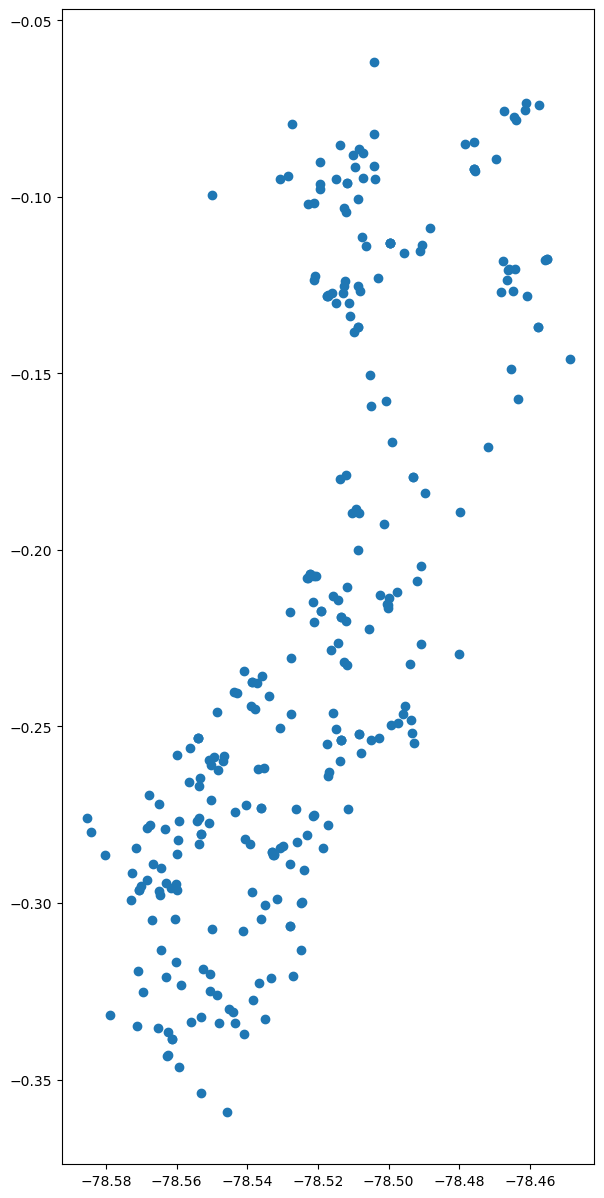

In [8]:
df_Centros_MIES = gpd.sjoin(df_MIES_quito,df_uquito,how='left')
df_Centros_MIES.dropna(subset=['dpa_parroq'], inplace = True )
df_Centros_MIES.plot()

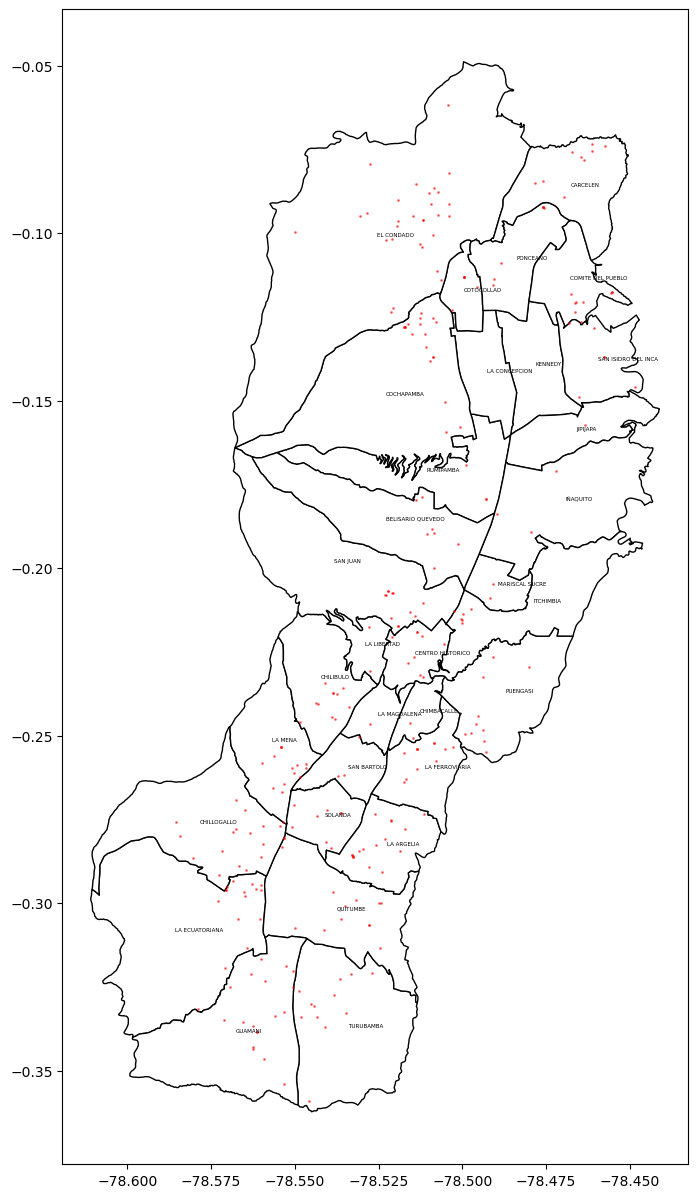

In [9]:
# Crear la figura y los ejes
fig, ax = plt.subplots()
ax.set_aspect('equal')

# Graficar los polígonos. 
df_uquito.plot(ax=ax, color='white', edgecolor='black')

# Graficar los puntos.
df_Centros_MIES.plot(ax=ax, marker='o', color='red', markersize=1, alpha=0.5)

# Agregar etiquetas a las zonas.
for x, y, label in zip(df_uquito.geometry.centroid.x, df_uquito.geometry.centroid.y, df_uquito['dpa_despar']):
    ax.annotate(label, (x, y), fontsize=4)

plt.show()

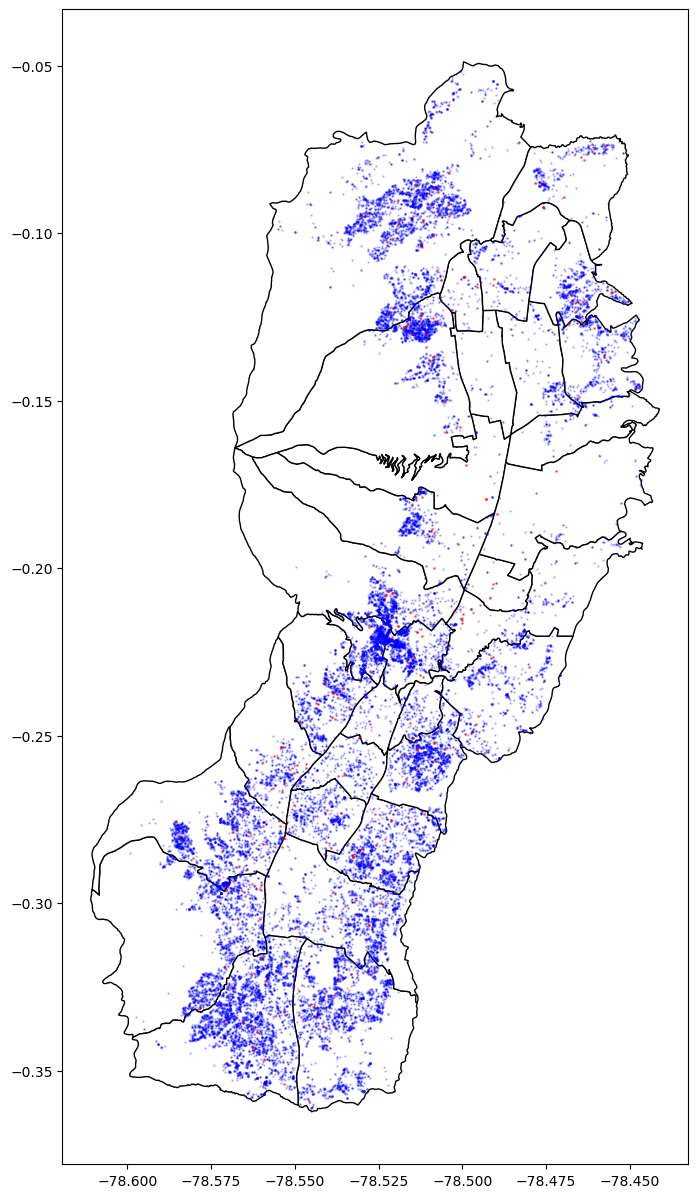

In [10]:


fig, ax = plt.subplots()

ax.set_aspect('equal')

df_uquito.plot(ax=ax, color='white', edgecolor='black')
df_MIES.plot(ax=ax, marker='o', color='blue', markersize=0.5, alpha=0.25)
df_Centros_MIES.plot(ax=ax, marker='o', color='red', markersize=1, alpha=0.5)
plt.show()


In [11]:
df_Centros_MIES2=df_Centros_MIES.set_crs(32717, allow_override=True) 

In [12]:
df_MIES2=df_MIES.set_crs(32717, allow_override=True) 

In [13]:
df_MIES2.crs

<Projected CRS: EPSG:32717>
Name: WGS 84 / UTM zone 17S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°W and 78°W, southern hemisphere between 80°S and equator, onshore and offshore. Ecuador. Peru.
- bounds: (-84.0, -80.0, -78.0, 0.0)
Coordinate Operation:
- name: UTM zone 17S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia en kilómetros entre dos puntos definidos por sus coordenadas
    latitud y longitud utilizando la fórmula del haversine.
    """
    # Radio de la Tierra en kilómetros
    R = 6371.0

    # Convertir coordenadas de grados a radianes
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # Diferencia de latitud y longitud
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Aplicar la fórmula del haversine
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distancia = R * c

    return distancia

# Calcular la distancia en kilómetros entre los puntos de hogares y los centros
distancias_km = []
for hogar in df_MIES2.itertuples():
    min_dist_km = float('inf')
    for centro in df_Centros_MIES2.itertuples():
        dist_km = haversine(hogar.geometry.y, hogar.geometry.x, centro.geometry.y, centro.geometry.x)
        if dist_km < min_dist_km:
            min_dist_km = dist_km
    distancias_km.append(min_dist_km)

# Agregar la distancia en kilómetros a los puntos de hogares
df_MIES2["distancia_km"] = distancias_km



KeyboardInterrupt: 

In [126]:
df_MIES2.distancia_km.mean()

0.42174793358657986

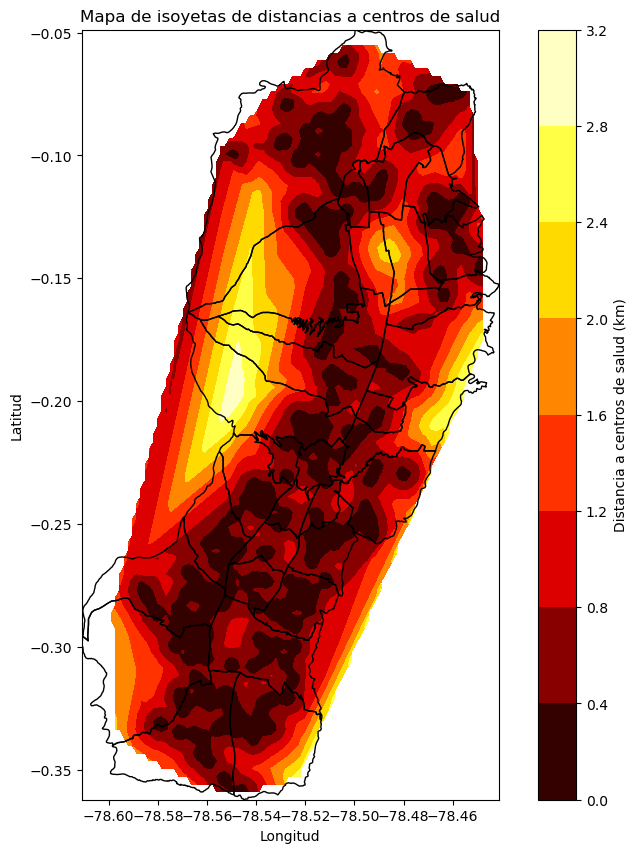

In [135]:
from scipy.interpolate import griddata

# Obtener los límites de los polígonos
x_min, y_min, x_max, y_max = df_uquito.total_bounds

# Crear una cuadrícula que se ajuste a los límites de los polígonos
x = np.linspace(x_min, x_max, resolucion)
y = np.linspace(y_min, y_max, resolucion)
X, Y = np.meshgrid(x, y)

# Interpolar las distancias desde los puntos de hogares a la cuadrícula regular
distancias_interpoladas = griddata((df_MIES2.geometry.x, df_MIES2.geometry.y), distancias_km, (X, Y), method='linear')

# Graficar el mapa de isoyetas
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, distancias_interpoladas, cmap='hot')
plt.colorbar(label='Distancia a centros de salud (km)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de isoyetas de distancias a centros de salud')
plt.gca().set_aspect('equal', adjustable='box')

# Graficar los polígonos sobre el mapa de isoyetas
df_uquito.plot(ax=plt.gca(), facecolor='none', edgecolor='black')

plt.show()


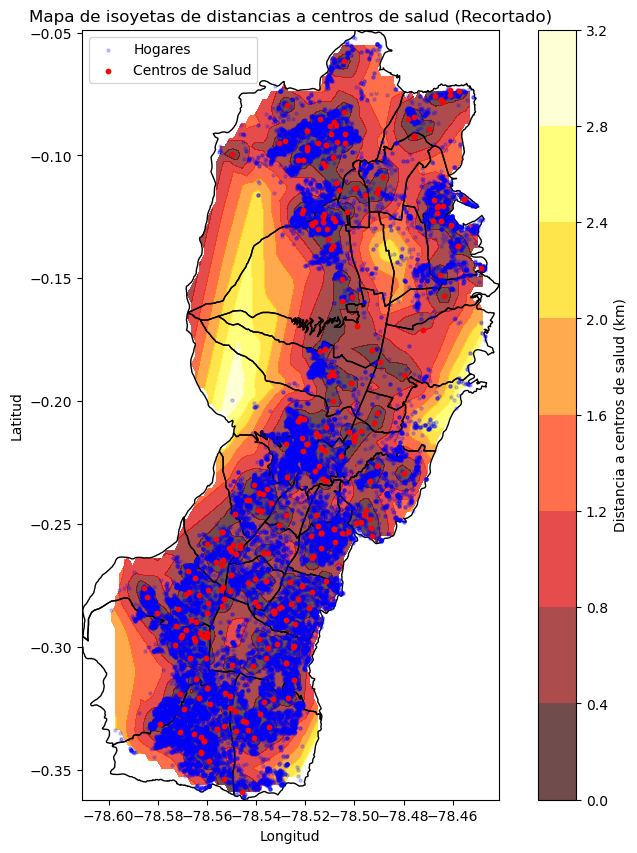

In [146]:
from matplotlib.path import Path

# Crear una máscara compuesta de todos los polígonos de los barrios
barrios_mask = np.zeros_like(X, dtype=bool)
for polygon in df_uquito.geometry:
    barrios_mask |= Path(polygon.exterior.coords).contains_points(np.vstack((X.flatten(), Y.flatten())).T).reshape(X.shape)

# Crear las isoyetas recortadas usando la máscara de los barrios
isoyetas_recortadas = np.where(barrios_mask, distancias_interpoladas, np.nan)

# Graficar el mapa de isoyetas recortadas
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, isoyetas_recortadas, cmap='hot', alpha=0.7)
plt.colorbar(label='Distancia a centros de salud (km)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de isoyetas de distancias a centros de salud (Recortado)')

# Graficar los polígonos de los barrios
df_uquito.plot(ax=plt.gca(), facecolor='none', edgecolor='black')

# Graficar los puntos de hogares y centros de salud
df_MIES2.plot(ax=plt.gca(), color='blue', markersize=5, label='Hogares',alpha=0.2)
df_Centros_MIES2.plot(ax=plt.gca(), color='red', markersize=10, label='Centros de Salud')

plt.legend()

plt.show()
